# Image-Based Structural Analysis
### Code created and maintained by Justin David Q. SAN JUAN, <br>email: jdqsj1997@yahoo.com, <br> website: justinsj.weebly.com

# Import Dependencies
#### Dependencies:
numpy: for handling data types (mostly handled as numpy arrays)<br>
Sequential (from keras.models): for CNN setup<br>
random: for pseudo-random shuffling of data<br>
cv2: for raw RBG image import and transformation to grayscale<br>
time: for measuring time elapsed per function<br>
##### Custom Classes:
ComponentSegmentation: for proposing regions of interest (RoI's)<br>
ExtractionPreprocessing: for trimming, noise removal, and resizing of image<br>
ComponentClassifierTraining: for loading the CNN model, training data, and training the model<br>
ComponentClassifierPredict: for using the CNN model to predict the class of preprocessed extractions<br>
ExtractionLabelling: for labelling ground truth bounding boxes and classes in problem images<br>
TestingClass: for testing the accuracy of a CNN model on the problem images<br>
<br>
print_image_bw is used to print a simple 2-D array<br>
gc: for clearing up space after acquiring data from larger datasets

In [1]:
from __future__ import print_function
import numpy as np

from keras.models import Sequential

import random

import cv2
import time

from component_segmentation import ComponentSegmentation
from extraction_preprocessing import ExtractionPreprocessing
from component_classifier_training import ComponentClassifierTraining
from component_classifier_predict import ComponentClassifierPredict
from extraction_labelling import ExtractionLabelling
from testing_class import TestingClass
from helper_functions import print_image_bw

import gc
gc.enable()

print('Done Importing...')

Using TensorFlow backend.


Done Importing...


# Hyper-parameters
#### Selective Search Parameters:
scale_input<br>
sigma_input<br>
min_size_input<br>
#### Noise Reduction Parameters:
min_shape: for minimum number of black pixels in bounding box<br>
min_height: for minimum height of bounding box<br>
min_width: for minimum width of bounding box<br>
<br>
buffer_zone: for expanding bounding box all directions<br>
min_area: for minimum area of bounding box<br>
min_black: for minimum number of black pixels in bounding box<br>
min_black_ratio: for minimum ratio of black pixels to the bounding box area<br>
#### Overlap Parameters:
overlap_repeats: for number of iterations for merging algorithm to be applied<br>
overlap_threshold: threshold of area overlap over union area for merging to be applied<br>
#### Removing Unconnected Pieces Parameters:
max_piece_percent: maximum percentage of piece to be removed<br>
(if percentage is larger, piece will not be removed as it is more likely an important piece)<br>
#### Extractions Preprocessing Parameters:
img_rows, img_cols: for classifier input shape<br>
wanted_w, wanted_h: for black pixels edges resizing boundary shape<br>
export_w, export_h: for overall image resizing shape ([export_w-wanted_w]/2 = horizontal buffer on each side)<br>
#### CNN Training Parameters:
num_classes: number of classes for classifier to predict<br>
TRAINING_RATIO_TRAIN: ratio of training samples to total number of samples<br>
TRAINING_RATIO_VAL: ratio of validation samples to total number of samples<br>
TRAINING_RATIO_TEST: ratio of test samples to total number of samples <br>
Note: TRAINING_RATIO_TEST is implicitly calculated as [1-{TRAINING_RATIO_TRAIN + TRAINING_RATIO_VAL}]<br>
dropout: dropout value to be used in all layers except last layer of Sketch-A-Net CNN model<br>
#### CNN Prediction Parameters:
min_percent_match: minimum probability of class prediction for that class to be set as the prediction<br>
min_confidence: minimum difference between first-highest % match and second-highest % match<br>
(higher difference means less ambiguity between first and second highest match, which means less likelihood of random object)<br>
##### The directory is also defined in the PATH variable.<br>The name of the CNN model data is defined in the name variable.<br>The training data set name for the CNN is defined in the data_set_name variable.

In [2]:
#selective search parameters
scale_input=200 #200 previous: #10
sigma_input=10 #10 previous: #15
min_size_input=10 #10 previous: #5

#noise reduction parameters
min_shape=10 #min. number of black pixels  
min_height=3 #min. height of bounding box
min_width=3 #min. width of bounding box

buffer_zone=2 #expand bounding box by this amount in all directions  
min_area=100 #min. area of bounding box
min_black=10 #min. number of black pixels
min_black_ratio=0.01 #min ratio of black pixels to the bounding box area

#Overlap parameters
overlap_repeats = 4 #set to 8
overlap_threshold = 0.3 #set to 0.3 (overlap has to be larger than the threshold)

#Removing unconnected pieces parameters
max_piece_percent=0.3  # set to 0.3

#Extractions preprocessing paramaters
img_rows, img_cols = 100,100
wanted_w, wanted_h, export_w, export_h = img_cols, img_rows, img_cols, img_rows

#CNN training parameters
num_classes = 64
TRAINING_RATIO_TRAIN = 0.7
TRAINING_RATIO_VAL = 0.15
dropout = 0

#CNN prediction parameters
min_percent_match = 0 # set to 0.7
min_confidence = 0 # set to 0.3

#Paths and names
PATH = 'C:/Users/JustinSanJuan/Desktop/Workspace/python/Testing Folder/' #must have "/" at the end

name = 'Sketch-a-Net_64_classes_100x100_0.0_all_100epochs'

data_set_name = 'Training_Samples_64_classes_100x100_all'

print('Done setting hyperparamters...')

Done setting hyperparamters...


# Load Image
Image (binary, grayscale, 2D, numpy array) for regions of interest proposals is loaded.

Loading image done... Time Elapsed : 0.31453776359558105 seconds...


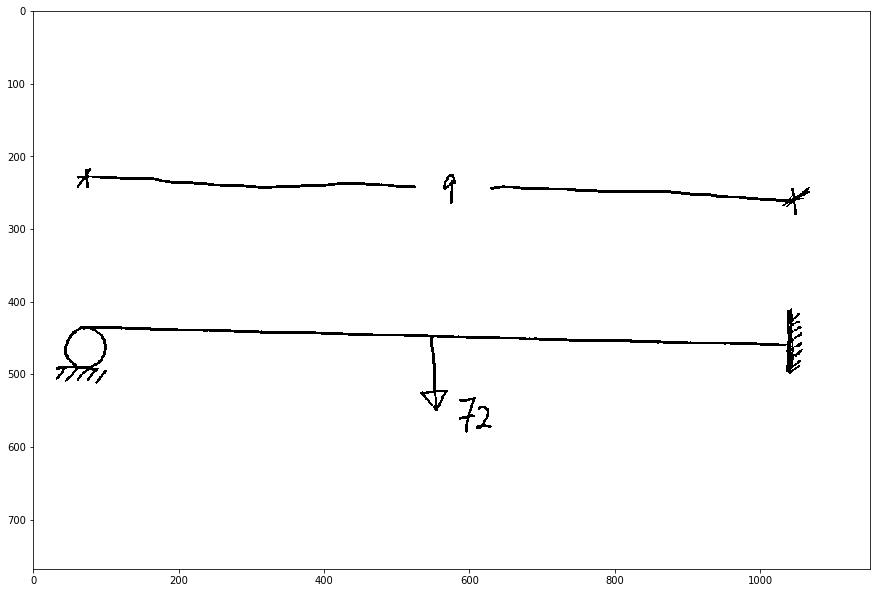

In [3]:
start = time.time() # Begin time measurement

image_index = 50
image_set = np.load(PATH+'easy_training_images.npy')
image = np.copy(image_set[:,:,image_index])
image_set = None #clear image_set
gc.collect() #clear unreferenced data

end = time.time()#record time
print('Loading image done... Time Elapsed : '+ str(end-start) + ' seconds...')
t1 = end-start

l,w = 15,15 #dimension scales of print
print_image_bw(image,l,w)

# Component Segmentation
##### Using the ComponentSegmentation class:
    1. Selective Search is applied to the image (to generate bounding boxes)
    2. A merging algorithm is applied to the selective search bounding boxes (to merge highly overlapping bounding boxes)
##### The ComponentSegmentation uses the following data for initialization:
    - image: binary (grayscale) 2-D array for region proposal
    - name: for unique prints saving
    - min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio: for noise reduction
    - overlap_repeats, overlap_threshold: for merging algorithm
##### Then, the RoI proposal is done using the custom search method, which uses the selective search hyper-parameters:
    - scale_input
    - sigma_input
    - min_size_input
##### Then, the merging algorithm is applied within the search function, and a merged_set is retrieved.

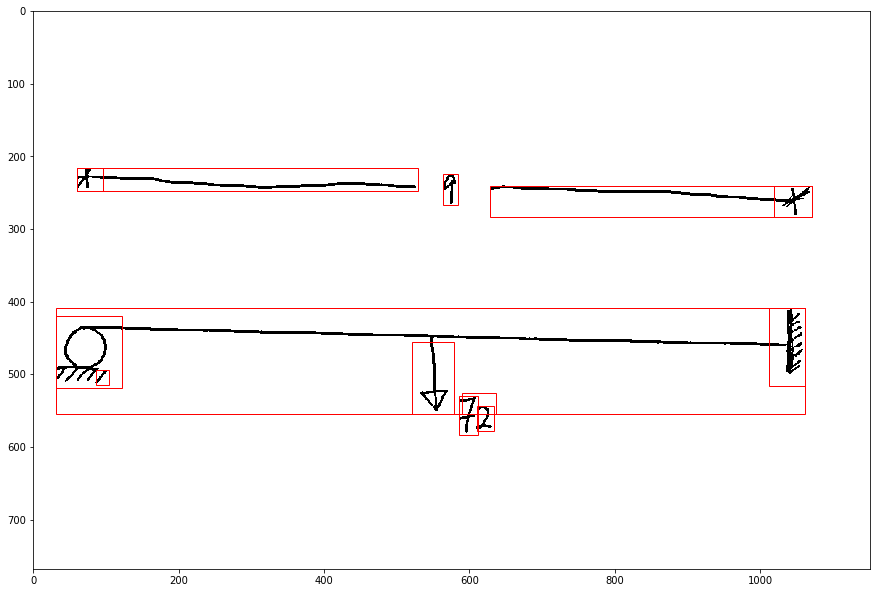

ComponentSegmentation done... Time Elapsed : 1.3621735572814941 seconds...


In [4]:
start = time.time() # Begin time measurement

#Create object ComponentSegmentation, which will use the search function to perform segmentation and merging.
segmentation_obj = ComponentSegmentation(image, name, min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio, overlap_repeats, overlap_threshold)
segmentation_obj.search(scale_input, sigma_input, min_size_input) # run search (segmentation code)
merged_set = segmentation_obj.merged_set

end = time.time()#record time
print('ComponentSegmentation done... Time Elapsed : '+ str(end-start) + ' seconds...')
t2 = end-start


# ExtractionPreprocessing
#### Merged set from ComponentSegmentation is passed to ExtractionPreprocessing and the following is applied:
    1. Trim: extra space around the farthest black pixels are removed
    2. Remove Unconnected Parts: extra pixels (from other components) captured by the bounding box are removed
    3. Trim: trimming again as empty spaces may be released
    4. Resize: extraction is resized to the prescribed 100x100 dimension using max pooling for downsampling to preserve data
ext_images = extraction images: list of 100x100 binary (grayscale) 2-D arrays<br>
ext_data = extraction data: list of x, y, w, h data of extractions bounding boxes<br> 
where:<br>
    - x, y: top-left corner coordinates of bounding box
    - w, h: width and height of bounding box respectively
#### The preprocess_extractions function is called and the extraction images and extraction data are acquired.
#### The plot_bounding_boxes_with_names function is then used to display the bounding boxes on the original image.

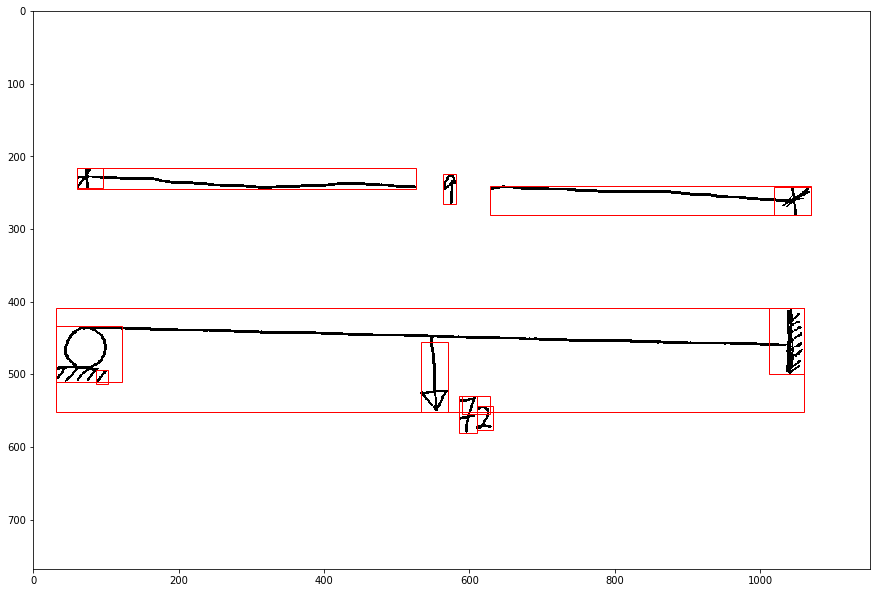

ExtractionPreprocessing done... Time Elapsed : 2.4127163887023926 seconds...


In [5]:
start = time.time() # Begin time measurement

#Transport data into ExtractionPreprocessing class, which will trim, remove unconnected parts, then trim, and resize
extraction_obj = ExtractionPreprocessing(image, name, merged_set)

# Get 4 lists from preprocess_extractions function
ext_images, ext_data = extraction_obj.preprocess_extractions(wanted_w, wanted_h, export_w, export_h, max_piece_percent)
extraction_obj.plot_bounding_boxes_with_names()

end = time.time()#record time
print('ExtractionPreprocessing done... Time Elapsed : '+ str(end-start) + ' seconds...')
t3 = end-start

# ComponentClassifierTraining (Not pre-trained)
### If model has been trained before:
### Then the train and save functions should be replaced with:
training_obj.model.load_weights(PATH+name+'.h5')
### Such that the below code is the following:
training_obj = ComponentClassifierTraining(PATH, data_set_name, num_classes, dropout, TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)<br>
training_obj.shuffle_data(training_obj.load_data(PATH,data_set_name),1000)<br>
<br>
#Model is Sketch_a_net<br>
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes, training_obj.X_train.shape[1:])<br>
training_obj.model.load_weights(PATH+name+'.h5')<br>
##### The ComponentClassifierTraining object is first initialized with:
    - PATH: working directory
    - data_set_name: for loading training data set
    - num_classes, dropout: CNN model parameters
    - TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL: training parameters
##### The shuffle_data is then called to shuffle the training data using a seed<br>The Sketch_A_Net model is then loaded<br>Then the model is trained with 100 epochs<br>Then the model weights are saved<br>Finally the trained model is stored in trained_model to be passed onto a ComponentClassifierPredict object
#### If model weights have been trained before, the training and saving is not required, and the load_weights function has to be called instead.

In [6]:
start = time.time() # Begin time measurement

seed = 1000
i = 1234
training_obj = ComponentClassifierTraining(PATH, data_set_name, num_classes, dropout, TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)
training_obj.shuffle_data(training_obj.load_data(PATH,data_set_name),seed)

#Model is Sketch_a_net
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes, training_obj.X_train.shape[1:])

#training_obj.train(100,seed)
#training_obj.save(name+'_'+str(i))
training_obj.model.load_weights(PATH+name+'.h5')

trained_model = training_obj.model

end = time.time()#record time
print('ComponentClassifierTraining done... Time Elapsed : '+ str(end-start) + ' seconds...')
t4 = end-start

ComponentClassifierTraining done... Time Elapsed : 5.250571012496948 seconds...


# ComponentClassifierPredict
### The ComponentClassifierPredict object is first initialized with the entropy-based hyperparameters:
    - min_percent_match
    - min_confidence
These parameters were explained in the Hyperparameters section above.
### The predict_classes function produces the following:
    - ext_class_index_list: ordered list of highest % match class predictions for each
The entropy-based modifications are applied to the above (such that if any of the two criteria are not satisfied, the prediction is classified as random)
    - ext_class_name_list: ordered list of corresponding names to ext_class_index_list
    - ext_match_first_max_percent_list: ordered list of corresponding first-highest match percentage
    - ext_match_second_max_percent_list: ordered list of corresponding second-highest match percentage

In [9]:
start = time.time() # Begin time measurement

prediction_obj = ComponentClassifierPredict(min_percent_match, min_confidence)

ext_class_index_list, ext_class_name_list, \
ext_match_first_max_percent_list, \
ext_match_second_max_percent_list = prediction_obj.predict_classes(ext_images,trained_model)

end = time.time()#record time
print('ComponentClassifierPredict done... Time Elapsed : '+ str(end-start) + ' seconds...')
t5 = end-start

[29, 11, 52, 12, 52, 2, 23, 23, 55, 9, 4, 7, 45]
ComponentClassifierPredict done... Time Elapsed : 0.3007657527923584 seconds...


# Printing Results

# ExtractionLabelling

In [8]:
#labelling_obj = ExtractionLabelling(PATH,
#                          ext_images, ext_data,ext_class_index, ext_class_name, 
#                          num_classes, img_rows, img_cols)
#
##labelling_obj.define_model(trained_model)
##labelling_obj.select_good_bounding_boxes(image, "all_" + str(image_index))
#labelling_obj.plot_ground_truths(image, "all_" + str(image_index))

# TestingClass